In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import sys
import gc
import pywt
sys.path.append('../Pytorch-UNet/')
sys.path.append('../wtvae/src/')
from unet.unet_model import UNet
from vae_models import WT, wt, IWT, iwt, IWTAE_128_Mask_2, IWTAE_512_Mask_2
from utils.utils import zero_patches, zero_mask, set_seed, save_plot, create_inv_filters, create_filters, zero_pad

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = '/hdd_e/han/data/imagenet/10c'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr_D = 0.0002
lr_G = 0.0002
lr_mn = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Output directory
output_dir = os.path.join('./iwt_model_256_outputs', 'unet_in_novae/')

# Devices
DEVICE0 = 'cuda:0'
DEVICE1 = 'cuda:1'

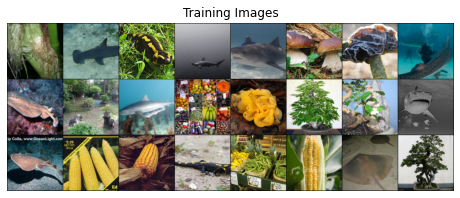

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))

# print(np.min(real_batch[0][0].numpy()))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:24], padding=2, normalize=False).cpu(),(1,2,0)))


In [4]:
def wt(vimg, filters, levels=1):
    bs = vimg.shape[0]
    h = vimg.size(2)
    w = vimg.size(3)
    vimg = vimg.reshape(-1, 1, h, w)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1], filters, levels-1)
        res[:,:1,32:,:] = res[:,:1,32:,:]*1.
        res[:,:1,:,32:] = res[:,:1,:,32:]*1.
        res[:,1:] = res[:,1:]*1.
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res.reshape(bs, -1, h, w)

def create_filters(device, wt_fn='bior2.2'):
    w = pywt.Wavelet(wt_fn)
    dec_hi = torch.Tensor(w.dec_hi[::-1]).to(device)
    dec_lo = torch.Tensor(w.dec_lo[::-1]).to(device)
    filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                           dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                           dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                           dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0)
    return filters

def iwt(vres, inv_filters, levels=1):
    bs = vres.shape[0]
    h = vres.size(2)
    w = vres.size(3)
    vres = vres.reshape(-1, 1, h, w)
    res = vres.contiguous().view(-1, h//2, 2, w//2).transpose(1, 2).contiguous().view(-1, 4, h//2, w//2).clone()
    if levels > 1:
        res[:,:1] = iwt(res[:,:1], inv_filters, levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding

    return res.reshape(bs, -1, h, w)

filters = create_filters(device='cuda:0')
inv_filters = create_inv_filters(device='cuda:0')

# cur_max = float('-inf')
# cur_min = float('inf')
# for i, data in enumerate(dataloader):
#     data_512 = data[0].to('cuda:0')
#     data_wt = wt(data_512, filters=filters, levels=3)[:, :, :32, :32]
#     cur_max = max(cur_max, torch.max(data_wt))
#     cur_min = min(cur_min, torch.min(data_wt))
# print(cur_max)
# print(cur_min)

tensor(11.9692, device='cuda:0')
tensor(-3.1186, device='cuda:0')


In [5]:
# shift = torch.ceil(-1*cur_min)
# scale = shift+torch.ceil(cur_max)

# print(shift, scale)

tensor(4., device='cuda:0') tensor(16., device='cuda:0')


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
def denormalize(data, shift, scale):
    return data*scale - shift
    
def normalize(data, shift, scale):
    return (data + shift) / scale

In [12]:
# Instantiate mask network for 128 x 128 (input: 32 x 32)
iwt_model_256 = UNet(n_channels=3, n_classes=3, bilinear=True)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  iwt_model_256 = nn.DataParallel(iwt_model_256, device_ids=[0, 1])

iwt_model_256 = iwt_model_256.to(DEVICE0)

# Set up optimizer
optimizer_mn_256 = optim.Adam(iwt_model_256.parameters(), lr=lr_mn)

# Train loss
train_losses = []

Let's use 2 GPUs!


In [13]:
# Loss function for UNet mask
def loss_fn(mask, mask_recon) -> Variable:
    BCE_wt = F.mse_loss(mask_recon.reshape(-1), mask.reshape(-1))

    return BCE_wt

In [14]:
iwt_model_256.train()

# Training 128 mask network
for epoch in range(0, num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        optimizer_mn_256.zero_grad()
        
        real_cpu = data[0].to(DEVICE0)
        real_cl = data[1].to(DEVICE0)
        Y = wt(real_cpu, filters, levels=3)
        Y_32 = Y[:, :, :32, :32]
        
        # Get real mask at 128 x 128 (2 WT on that so each patch is 32 x 32)
        real_mask_256 = zero_mask(Y, 3, 1)
        real_mask_256 = iwt(real_mask_256, inv_filters, levels=3)
        
        with torch.no_grad():
            # Get reconstruction from AE & DSVAE
            # Apply WT twice to get 32 x 32 low freq patch and pad with zeros to create 128 x 128
            Y_32_padded = zero_pad(Y_32, 256, device=DEVICE0)
            Y_32_low = iwt(Y_32_padded, inv_filters, levels=3)

        # Run through 128 mask network and get reconstructed image
        recon_mask_256 = iwt_model_256(Y_32_low.to(DEVICE0))
        recon_mask_256_wt = wt(recon_mask_256.to(DEVICE0), filters, levels=3)
        recon_mask_256_wt[:, :, :32, :32] = Y_32_hat
        recon_img_256 = iwt(recon_mask_256_wt, inv_filters, levels=3)
        
        loss = loss_fn(real_mask_256.to(DEVICE0), recon_mask_256)
        loss.backward()
        
        optimizer_mn_256.step()
        
        if i % 50 == 0:
            print('[{}/{}][{}/{}]\t Loss: {}'.format(epoch, num_epochs, i, len(dataloader), loss.item()))
            train_losses.append(loss.item())
        
        gc.collect()
        torch.cuda.empty_cache()
        
    
    real_img_256_padded = Y.clone()
    real_img_256_padded[:, :, :32, :32] = Y_32_hat
    real_img_256_padded = iwt(real_img_256_padded, inv_filters, levels=3)
        
    save_image(real_mask_256.cpu(), output_dir + 'real_mask{}.png'.format(epoch))
    save_image(recon_mask_256.cpu(), output_dir + 'recon_mask{}.png'.format(epoch))
    save_image(recon_img_256.cpu(), output_dir + 'recon_img{}.png'.format(epoch))
    save_image(Y_32_low.cpu(), output_dir + 'low_img_full{}.png'.format(epoch))
    save_image(real_img_256_padded.cpu(), output_dir + 'real_img_256_{}.png'.format(epoch))
    save_image(real_cpu.cpu(), output_dir + 'img{}.png'.format(epoch))
    
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': iwt_model_256.state_dict(),
            'optimizer_state_dict': optimizer_mn_256.state_dict(),
            }, output_dir + '/iwt_model_256_epoch{}.pth'.format(epoch))


np.save(output_dir + 'train_losses.npy', train_losses)

[0/300][0/181]	 Loss: 0.12466230243444443
[0/300][50/181]	 Loss: 0.007390279322862625
[0/300][100/181]	 Loss: 0.006784643977880478
[0/300][150/181]	 Loss: 0.006673671305179596
[1/300][0/181]	 Loss: 0.006678559817373753
[1/300][50/181]	 Loss: 0.005801171995699406
[1/300][100/181]	 Loss: 0.0066646309569478035
[1/300][150/181]	 Loss: 0.006620969157665968
[2/300][0/181]	 Loss: 0.0060664573684334755
[2/300][50/181]	 Loss: 0.005398089066147804
[2/300][100/181]	 Loss: 0.007221635431051254
[2/300][150/181]	 Loss: 0.005062836688011885
[3/300][0/181]	 Loss: 0.005953837186098099
[3/300][50/181]	 Loss: 0.005743496119976044
[3/300][100/181]	 Loss: 0.006474047899246216
[3/300][150/181]	 Loss: 0.0054914690554142
[4/300][0/181]	 Loss: 0.00567830353975296
[4/300][50/181]	 Loss: 0.006501013413071632
[4/300][100/181]	 Loss: 0.006623569875955582
[4/300][150/181]	 Loss: 0.005724621471017599
[5/300][0/181]	 Loss: 0.004953665658831596
[5/300][50/181]	 Loss: 0.0068483417853713036
[5/300][100/181]	 Loss: 0.007

In [1]:

torch.save({
    'model_state_dict': iwt_model_256.state_dict(),
    'optimizer_state_dict': optimizer_mn_256.state_dict(),
    }, output_dir + '/iwt_model_64_epoch{}.pth'.format(299))

NameError: name 'torch' is not defined

In [36]:
i = 4
j = 1
save_image(Y_32_norm_hat[i], output_dir + 'recon{}.png'.format(j))
t = torch.cat((Y_32_low[i].unsqueeze(0), recon_img_256[i].unsqueeze(0), recon_mask_256[i].unsqueeze(0), real_cpu[i].unsqueeze(0)), dim=0)
save_image(t, output_dir + 'recon_patch{}.png'.format(j))


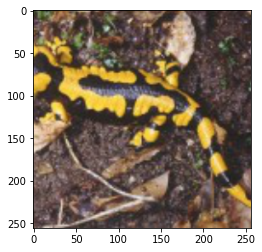

In [30]:
plt.imshow(real_cpu[0].cpu().numpy().transpose(1,2,0))

In [37]:
recon_mask_real_img_256_wt = recon_mask_256_wt.clone()
recon_mask_real_img_256_wt[:, :, :32, :32] = Y_32
recon_img_256_reallf = iwt(recon_mask_real_img_256_wt, inv_filters, levels=3)
save_image(recon_img_256_reallf.cpu(), output_dir + 'recon_img_real_lf.png')


In [41]:
iwt_model_256.eval()
with torch.no_grad():
    Y_32_padded_real = zero_pad(Y_32, 256, device=DEVICE0)
    Y_32_low_real = iwt(Y_32_padded_real, inv_filters, levels=3)
    
    recon_mask_256_real = iwt_model_256(Y_32_low_real.to(DEVICE0))
    recon_mask_256_wt_real = wt(recon_mask_256_real.to(DEVICE0), filters, levels=3)
    recon_mask_256_wt_real[:, :, :32, :32] = Y_32
    recon_img_256_real = iwt(recon_mask_256_wt_real, inv_filters, levels=3)
    
    save_image(recon_img_256_real.cpu(), output_dir + 'recon_img_real_changed_mask.png')
    save_image(recon_mask_256_real.cpu(), output_dir + 'recon_mask_real_changed_mask.png')